In [1]:
import pandas as pd
import numpy as np

def create_taste_profile_df(data_path, column_names=['user_id', 'song_id', 'play_count']):
    df = pd.read_csv(data_path, header=None, names=column_names)
    return df

def create_representative_sample(big_df, target_size_ratio=0.2, seed=42):
    """
    Create a representative sample of the dataset that maintains similar distributions
    """
    target_size = int(len(big_df) * target_size_ratio)
    
    play_counts = big_df['play_count'].value_counts().sort_index()
    cumsum = play_counts.cumsum()
    total = cumsum.iloc[-1]
    
    num_bins = 10
    bin_size = total / num_bins
    bins = [0]  # Start with 0
    current_sum = 0
    current_bin = 1
    
    for count, freq in play_counts.items():
        current_sum += freq
        if current_sum >= bin_size * current_bin and len(bins) < num_bins:
            bins.append(count)
            current_bin += 1
    bins.append(float('inf'))  # Add infinity as the last bin
    
    # Create bin labels
    big_df['play_count_bin'] = pd.cut(big_df['play_count'], bins=bins, labels=False)
    
    # Sample within each bin
    sampled_dfs = []
    for bin_label in range(num_bins):
        bin_data = big_df[big_df['play_count_bin'] == bin_label]
        if len(bin_data) > 0:
            bin_sample_size = int(np.ceil(len(bin_data) * target_size_ratio))
            # Sample from this bin
            bin_sample = bin_data.sample(
                n=min(bin_sample_size, len(bin_data)),
                random_state=seed
            )
            sampled_dfs.append(bin_sample)
    
    sampled_df = pd.concat(sampled_dfs)
    
    # Drop the temporary binning column
    sampled_df = sampled_df.drop('play_count_bin', axis=1)
    
    return sampled_df

def analyze_listening_patterns(df):
    """
    Analyze the variation in listening patterns
    """
    analysis = {
        'user_stats': {
            'total_users': df['user_id'].nunique(),
            'songs_per_user': {
                'mean': df.groupby('user_id')['song_id'].count().mean(),
                'std': df.groupby('user_id')['song_id'].count().std(),
                'median': df.groupby('user_id')['song_id'].count().median(),
                'percentiles': df.groupby('user_id')['song_id'].count().quantile([0.25, 0.75]).to_dict()
            },
            'plays_per_user': {
                'mean': df.groupby('user_id')['play_count'].sum().mean(),
                'std': df.groupby('user_id')['play_count'].sum().std(),
                'median': df.groupby('user_id')['play_count'].sum().median(),
                'percentiles': df.groupby('user_id')['play_count'].sum().quantile([0.25, 0.75]).to_dict()
            }
        },
        'song_stats': {
            'total_songs': df['song_id'].nunique(),
            'plays_per_song': {
                'mean': df.groupby('song_id')['play_count'].sum().mean(),
                'std': df.groupby('song_id')['play_count'].sum().std(),
                'median': df.groupby('song_id')['play_count'].sum().median(),
                'percentiles': df.groupby('song_id')['play_count'].sum().quantile([0.25, 0.75]).to_dict()
            },
            'users_per_song': {
                'mean': df.groupby('song_id')['user_id'].count().mean(),
                'std': df.groupby('song_id')['user_id'].count().std(),
                'median': df.groupby('song_id')['user_id'].count().median(),
                'percentiles': df.groupby('song_id')['user_id'].count().quantile([0.25, 0.75]).to_dict()
            }
        },
        'play_count_stats': {
            'mean': df['play_count'].mean(),
            'std': df['play_count'].std(),
            'median': df['play_count'].median(),
            'percentiles': df['play_count'].quantile([0.25, 0.75]).to_dict(),
            'value_counts': df['play_count'].value_counts().sort_index().to_dict()
        }
    }
    return analysis

def compare_datasets(df1, df2, dataset1_name="Dataset 1", dataset2_name="Dataset 2"):
    """
    Compare two datasets and return their similarity metrics
    """
    analysis1 = analyze_listening_patterns(df1)
    analysis2 = analyze_listening_patterns(df2)
    
    comparison = {
        'size_ratio': len(df2) / len(df1),
        'user_coverage': len(set(df2['user_id']) & set(df1['user_id'])) / len(set(df1['user_id'])),
        'song_coverage': len(set(df2['song_id']) & set(df1['song_id'])) / len(set(df1['song_id'])),
        'play_count_distribution': {
            'mean_difference': abs(analysis2['play_count_stats']['mean'] - analysis1['play_count_stats']['mean']) / analysis1['play_count_stats']['mean'],
            'std_difference': abs(analysis2['play_count_stats']['std'] - analysis1['play_count_stats']['std']) / analysis1['play_count_stats']['std']
        }
    }
    return comparison

In [2]:
# Load the datasets
big_df = create_taste_profile_df('user_plays_1m_users_data.csv')
small_df = create_taste_profile_df('user_plays(in).csv')

# Analyze both datasets
big_analysis = analyze_listening_patterns(big_df)
small_analysis = analyze_listening_patterns(small_df)

# Compare them to understand how representative the small dataset is
comparison = compare_datasets(big_df, small_df, "Big Dataset", "Small Dataset")

# Create a new representative sample
new_sample = create_representative_sample(big_df, target_size_ratio=0.1)

In [3]:
new_sample.to_csv('new_sample_10p.csv', index=False)


### Data Analysis

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_variety_patterns(df, plot=True):
    """
    Analyze and visualize variety patterns in the Echo Nest dataset
    """
    # Basic statistics
    stats = {
        'total_interactions': len(df),
        'unique_users': df['user_id'].nunique(),
        'unique_songs': df['song_id'].nunique(),
        'avg_plays': df['play_count'].mean(),
        'median_plays': df['play_count'].median()
    }
    
    # User engagement patterns
    user_patterns = {
        'songs_per_user': df.groupby('user_id')['song_id'].nunique().describe(),
        'total_plays_per_user': df.groupby('user_id')['play_count'].sum().describe()
    }
    
    # Song popularity patterns
    song_patterns = {
        'listeners_per_song': df.groupby('song_id')['user_id'].nunique().describe(),
        'total_plays_per_song': df.groupby('song_id')['play_count'].sum().describe()
    }
    
    # Calculate play count distribution
    play_dist = df['play_count'].value_counts().sort_index()
    
    if plot:
        # Create a figure with subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Plot 1: Distribution of songs per user
        sns.histplot(df.groupby('user_id')['song_id'].nunique(), 
                    bins=50, ax=axes[0,0])
        axes[0,0].set_title('Distribution of Songs per User')
        axes[0,0].set_xlabel('Number of Songs')
        axes[0,0].set_ylabel('Number of Users')
        
        # Plot 2: Distribution of users per song
        sns.histplot(df.groupby('song_id')['user_id'].nunique(), 
                    bins=50, ax=axes[0,1])
        axes[0,1].set_title('Distribution of Users per Song')
        axes[0,1].set_xlabel('Number of Users')
        axes[0,1].set_ylabel('Number of Songs')
        
        # Plot 3: Play count distribution (log scale)
        sns.histplot(df['play_count'], bins=50, ax=axes[1,0])
        axes[1,0].set_title('Distribution of Play Counts')
        axes[1,0].set_xlabel('Play Count')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].set_yscale('log')
        
        # Plot 4: Total plays per user distribution
        sns.histplot(df.groupby('user_id')['play_count'].sum(), 
                    bins=50, ax=axes[1,1])
        axes[1,1].set_title('Distribution of Total Plays per User')
        axes[1,1].set_xlabel('Total Plays')
        axes[1,1].set_ylabel('Number of Users')
        
        plt.tight_layout()
        plt.show()
    
    return {
        'basic_stats': stats,
        'user_patterns': user_patterns,
        'song_patterns': song_patterns,
        'play_distribution': play_dist.head(10).to_dict()  # Top 10 most common play counts
    }

def print_analysis_results(results):
    """
    Print the analysis results in a readable format
    """
    print("\n=== BASIC STATISTICS ===")
    for key, value in results['basic_stats'].items():
        print(f"{key}: {value:.2f}")
    
    print("\n=== USER PATTERNS ===")
    print("\nSongs per user:")
    print(results['user_patterns']['songs_per_user'])
    
    print("\nTotal plays per user:")
    print(results['user_patterns']['total_plays_per_user'])
    
    print("\n=== SONG PATTERNS ===")
    print("\nListeners per song:")
    print(results['song_patterns']['listeners_per_song'])
    
    print("\nTotal plays per song:")
    print(results['song_patterns']['total_plays_per_song'])
    
    print("\n=== MOST COMMON PLAY COUNTS ===")
    for plays, count in results['play_distribution'].items():
        print(f"Play count {plays}: {count} occurrences")

In [5]:
def create_df(path, column_names=['user_id', 'song_id', 'play_count']):
    df = pd.read_csv(path, header=None, names=column_names)
    num_rows = len(df)
    print(num_rows)
    results = analyze_variety_patterns(df)

    print_analysis_results(results)

1048575


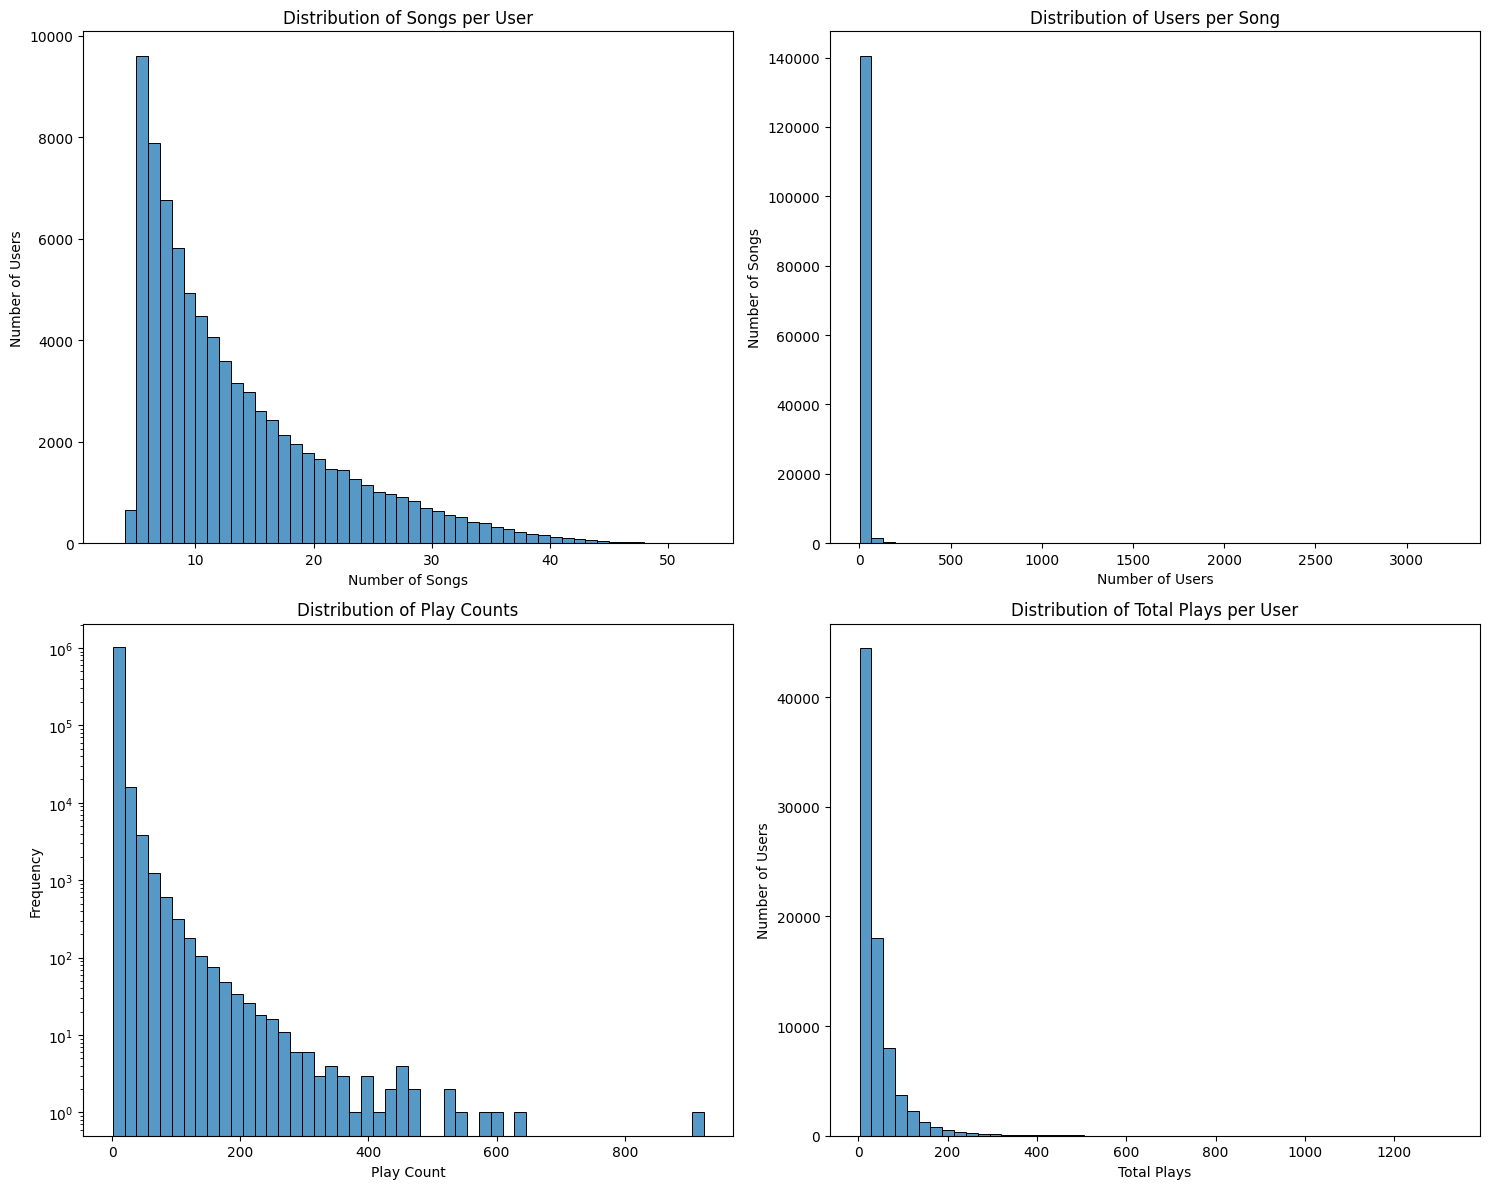


=== BASIC STATISTICS ===
total_interactions: 1048575.00
unique_users: 80367.00
unique_songs: 142628.00
avg_plays: 3.27
median_plays: 1.00

=== USER PATTERNS ===

Songs per user:
count    80367.000000
mean        13.047333
std          8.008915
min          3.000000
25%          7.000000
50%         11.000000
75%         17.000000
max         53.000000
Name: song_id, dtype: float64

Total plays per user:
count    80367.000000
mean        42.683726
std         54.565405
min          3.000000
25%         13.000000
50%         26.000000
75%         51.000000
max       1326.000000
Name: play_count, dtype: float64

=== SONG PATTERNS ===

Listeners per song:
count    142628.000000
mean          7.351817
std          35.098833
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max        3241.000000
Name: user_id, dtype: float64

Total plays per song:
count    142628.000000
mean         24.051119
std         171.229641
min           1.000000
25%       

In [6]:
create_df('user_plays(in).csv')

2418684


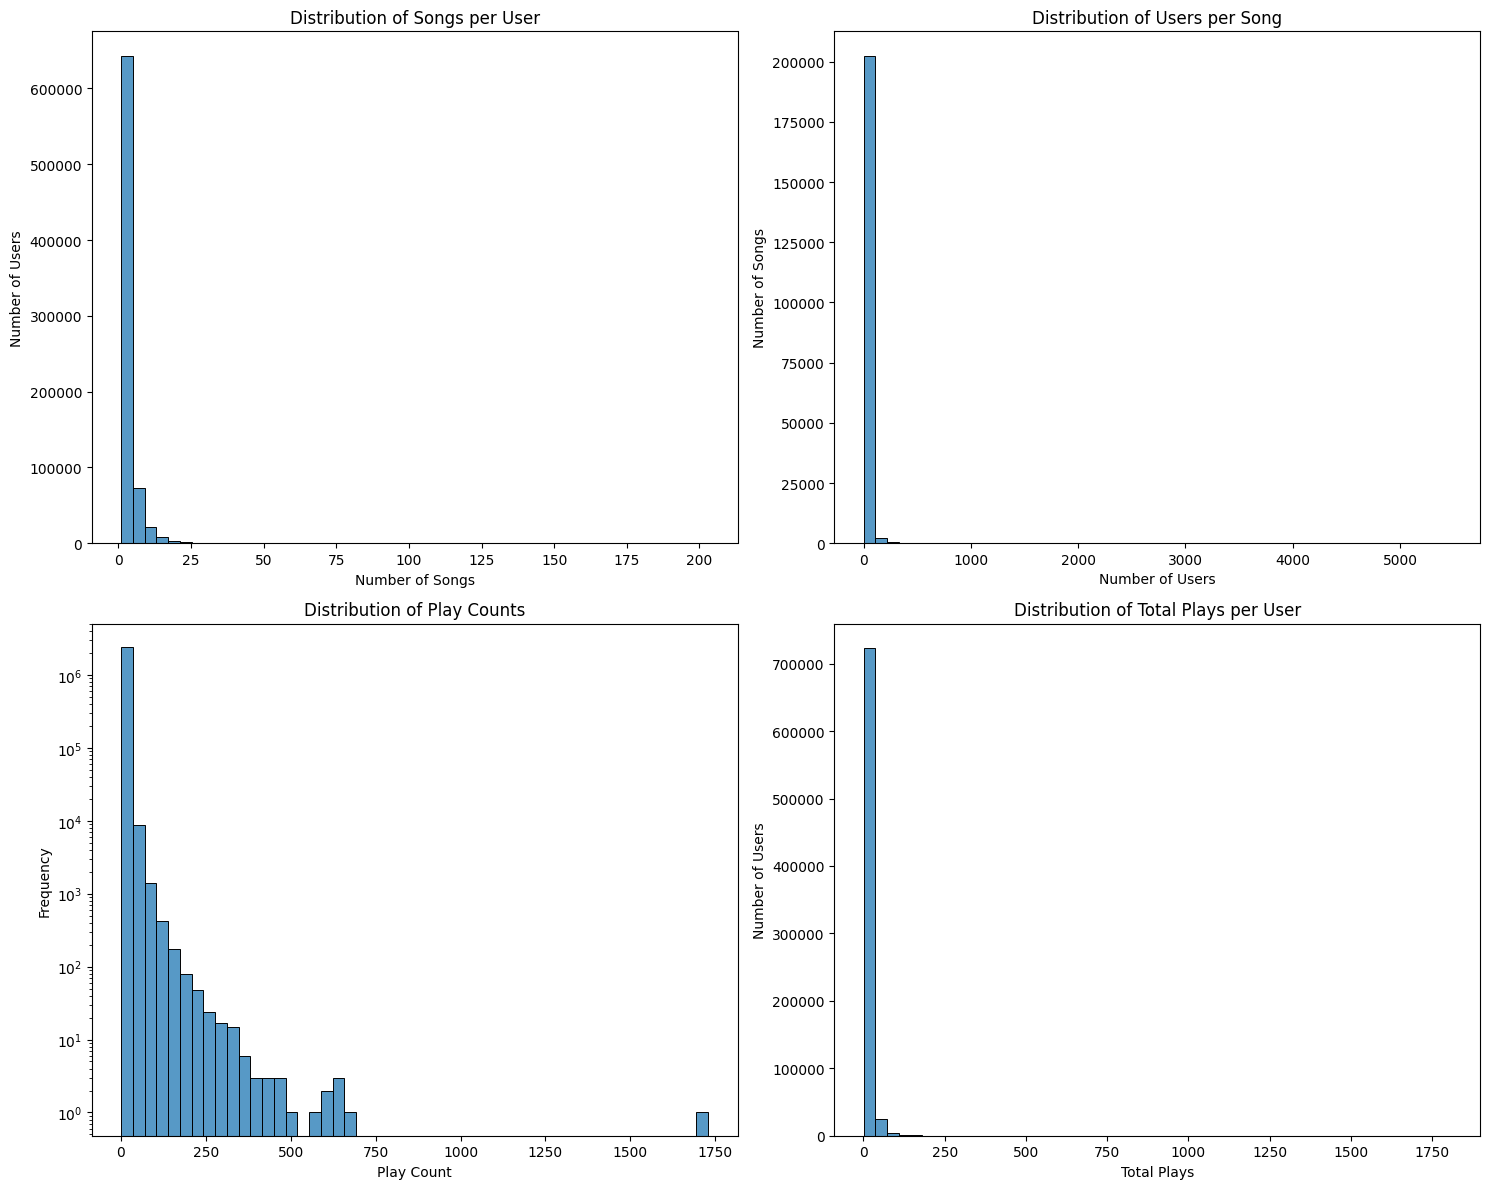


=== BASIC STATISTICS ===
total_interactions: 2418684.00
unique_users: 753307.00
unique_songs: 205755.00
avg_plays: 2.86
median_plays: 1.00

=== USER PATTERNS ===

Songs per user:
count    753307.000000
mean          3.210755
std           3.413333
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         203.000000
Name: song_id, dtype: float64

Total plays per user:
count    753307.000000
mean          9.183867
std          15.011403
min           1.000000
25%           2.000000
50%           4.000000
75%          10.000000
max        1807.000000
Name: play_count, dtype: float64

=== SONG PATTERNS ===

Listeners per song:
count    205755.000000
mean         11.755165
std          54.234575
min           1.000000
25%           1.000000
50%           2.000000
75%           7.000000
max        5472.000000
Name: user_id, dtype: float64

Total plays per song:
count    205755.000000
mean         33.623829
std         220.893082
min           1.

In [11]:
create_df('new_sample_5p.csv')

48373586


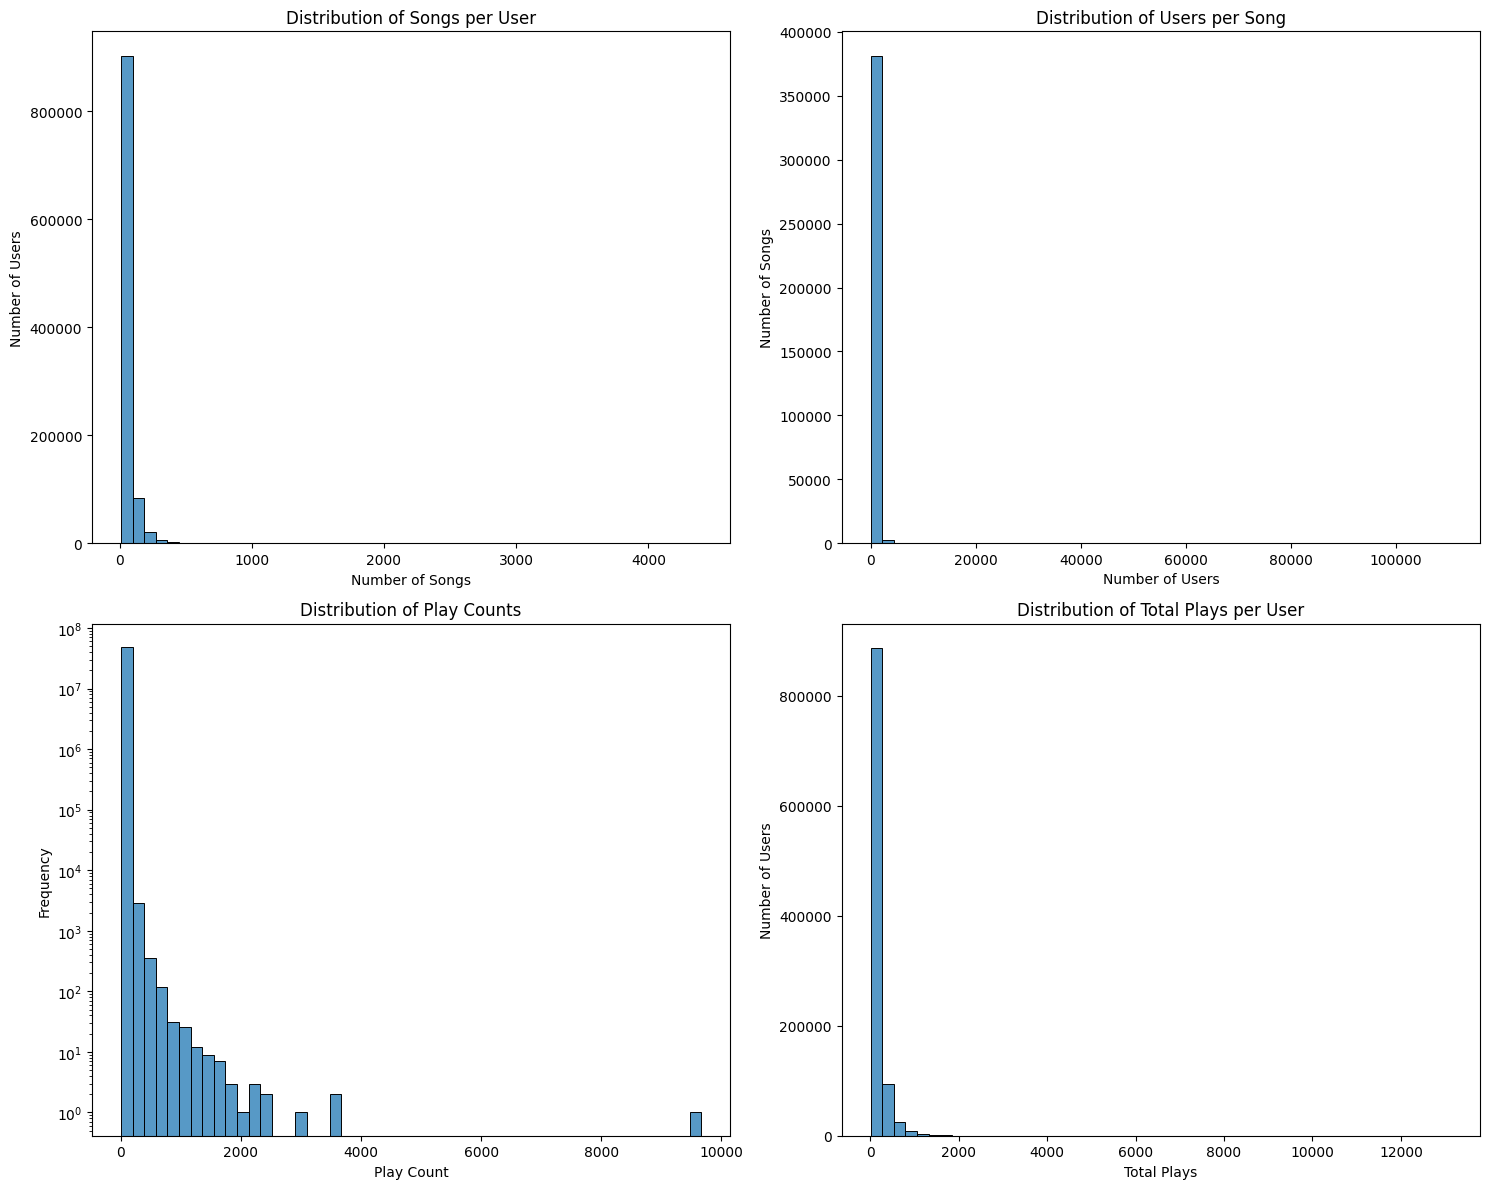


=== BASIC STATISTICS ===
total_interactions: 48373586.00
unique_users: 1019318.00
unique_songs: 384546.00
avg_plays: 2.87
median_plays: 1.00

=== USER PATTERNS ===

Songs per user:
count    1.019318e+06
mean     4.745682e+01
std      5.781573e+01
min      1.000000e+01
25%      1.600000e+01
50%      2.700000e+01
75%      5.500000e+01
max      4.400000e+03
Name: song_id, dtype: float64

Total plays per user:
count    1.019318e+06
mean     1.360520e+02
std      1.845255e+02
min      1.000000e+01
25%      3.400000e+01
50%      7.300000e+01
75%      1.630000e+02
max      1.313200e+04
Name: play_count, dtype: float64

=== SONG PATTERNS ===

Listeners per song:
count    384546.000000
mean        125.794017
std         799.025834
min           1.000000
25%           4.000000
50%          13.000000
75%          52.000000
max      110479.000000
Name: user_id, dtype: float64

Total plays per song:
count    384546.000000
mean        360.633690
std        3256.809395
min           1.000000
25%    

In [8]:
create_df('user_plays_1m_users_data.csv')